# Inżynieria Uczenia Maszynowego

Studenci:
```
Bartłomiej Krawczyk
Mateusz Brzozowski
```

## Temat

> “Jakiś czas temu wprowadziliśmy konta premium, które uwalniają użytkowników od słuchania reklam. Nie są one jednak jeszcze zbyt popularne – czy możemy się dowiedzieć, które osoby są bardziej skłonne do zakupu takiego konta?”

In [1]:
import itertools
import numpy as np
import pandas as pd
import pickle
import requests
import seaborn as sns

from IPython.display import display
from matplotlib import pyplot as plt
from math import sqrt
from scipy.stats import uniform
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from statistics import stdev, mean
from typing import Any, Dict, Optional
from xgboost import XGBClassifier

from microservice import IUMModel
from utility import Model

## Cechy i funkcje celu

Do trenowania naszych modeli wykorzystaliśmy następujące cechy:
- `number_of_advertisements`, ilość odtworzonych reklam w danym miesiącu
- `number_of_tracks`, ilość przesłuchanych utworów w danym miesiącu
- `number_of_skips`, ilość pominiętych utworów w danym miesiącu
- `number_of_likes`, liczba danych lików w danym miesiącu
- `number_of_liked_tracks_listened`, liczba przesłuchanych utworów w danym miesiącu, które w momencie odtworzenia były polubione
- `number_of_tracks_in_favourite_genre`, liczba przesłuchanych utworów z ulubionego gatunku u danym miesiącu
- `total_number_of_favourite_genres_listened`, liczba przesłuchanych gatunków w danym miesiącu należących do twoich ulubionych
- `average_popularity_in_favourite_genres`, średnia popularność utworów wśród ulubionych gatunków w danym miesiącu
- `total_tracks_duration_ms`, całkowity czas przesłuchanych utworów w danym miesiącu
- `number_of_different_artists`, ilość przesłuchanych artystów w danym miesiącu
- `average_release_date`, średnia data przesłuchanych piosenek w danym miesiącu
- `average_duration_ms`, średni czas trwania utworów przesłuchanych w danym miesiącu
- `explicit_tracks_ratio`, średnia ilość "wulgarnych" utworów przesłuchanych w danym miesiącu
- `average_popularity`, średnia popularność przesłuchanych utworów w danym miesiącu
- `average_acousticness`, średnia akustyka przesłuchanych utworów w danym miesiącu
- `average_danceability`, średnia taneczność przesłuchanych utworów w danym miesiącu
- `average_energy`, średnia moc przesłuchanych utworów w danym miesiącu
- `average_instrumentalness`, średnia ilość utworów z wokalem przesłuchanych w danym miesiącu
- `average_liveness`, średnie brzmienie utworów na żywo przesłuchanych w danym miesiącu
- `average_loudness`, średnia głośność przesłuchanych utworów w danym miesiącu
- `average_speechiness`, średnia ilość wokalu w utworach przesłuchanych w danym miesiącu
- `average_tempo`, średnia prędkość przesłuchanych utworów w danym miesiącu
- `average_valence`, średnia emocjonalność przesłuchanych utworów w danym miesiącu
- `average_track_name_length`, średnia długość nazwy utworów przesłuchanych w danym miesiącu
- `average_daily_cost`, średni koszt utrzymania przesłuchanych piosenek w danym miesiącu

Posiadamy również dwie funkcje celu:
- `premium_user_numerical`, gdzie będziemy przewidywać, czy użytkownik kiedykolwiek kupi premium
- `will_buy_premium_next_month_numerical` przedstawiająca to czy użytkownik zakupi premium w przeciągu następnych 30 dni.


In [2]:
FEATURE_VERSION = 'v1'
FEATURE_PATH = f'features/{FEATURE_VERSION}/feature.csv'

FEATURES = [
    'number_of_advertisements',
    'number_of_tracks',
    'number_of_skips',
    'number_of_likes',
    'number_of_liked_tracks_listened',
    'number_of_tracks_in_favourite_genre',
    'total_number_of_favourite_genres_listened',
    'average_popularity_in_favourite_genres',
    'total_tracks_duration_ms',
    'number_of_different_artists',
    'average_release_date',
    'average_duration_ms',
    'explicit_tracks_ratio',
    'average_popularity',
    'average_acousticness',
    'average_danceability',
    'average_energy',
    'average_instrumentalness',
    'average_liveness',
    'average_loudness',
    'average_speechiness',
    'average_tempo',
    'average_valence',
    'average_track_name_length',
    'average_daily_cost',
]

TARGETS = [
    'premium_user_numerical',
    'will_buy_premium_next_month_numerical'
]

TARGET_AND_FEATURES = TARGETS + FEATURES

In [3]:
data_frame = pd.read_csv(FEATURE_PATH)

### Przykładowe wartości cech oraz funkcji celu

In [4]:
data_frame.head()

,user_id,year,month,premium_user_numerical,will_buy_premium_next_month_numerical,number_of_premium,number_of_advertisements,number_of_tracks,number_of_skips,number_of_likes,...,average_danceability,average_energy,average_instrumentalness,average_liveness,average_loudness,average_speechiness,average_tempo,average_valence,average_track_name_length,average_daily_cost
0,212,2020,2,1,0,0,10,30,16,8,...,0.542767,0.600467,0.094653,0.179113,-10.158167,0.049070,121.964467,0.588167,22.233333,0.012134
1,212,2020,7,1,0,0,5,16,8,2,...,0.499000,0.675250,0.150966,0.226225,-8.795062,0.061812,123.069063,0.452131,22.687500,0.014780
2,212,2020,1,1,0,0,14,39,21,12,...,0.487000,0.691667,0.119363,0.235690,-9.491795,0.064918,123.745769,0.564369,19.461538,0.012399
3,212,2020,3,1,0,0,3,20,9,6,...,0.516700,0.637150,0.069641,0.189545,-8.409150,0.053715,121.415600,0.586000,21.250000,0.012706
4,212,2020,8,1,0,0,13,40,22,12,...,0.513525,0.642350,0.112645,0.285203,-9.562400,0.055282,120.922325,0.510517,24.000000,0.013076


### Macierz korelacji cech z wartościami przewidywanymi
Sprawdzamy korelację cech, które nie są zbytnio skorelowane między sobą, a za to są skorelowane z targetem. Na jej podstawie wybieramy wszystkie cechy, będą one używane do trenowania modeli.

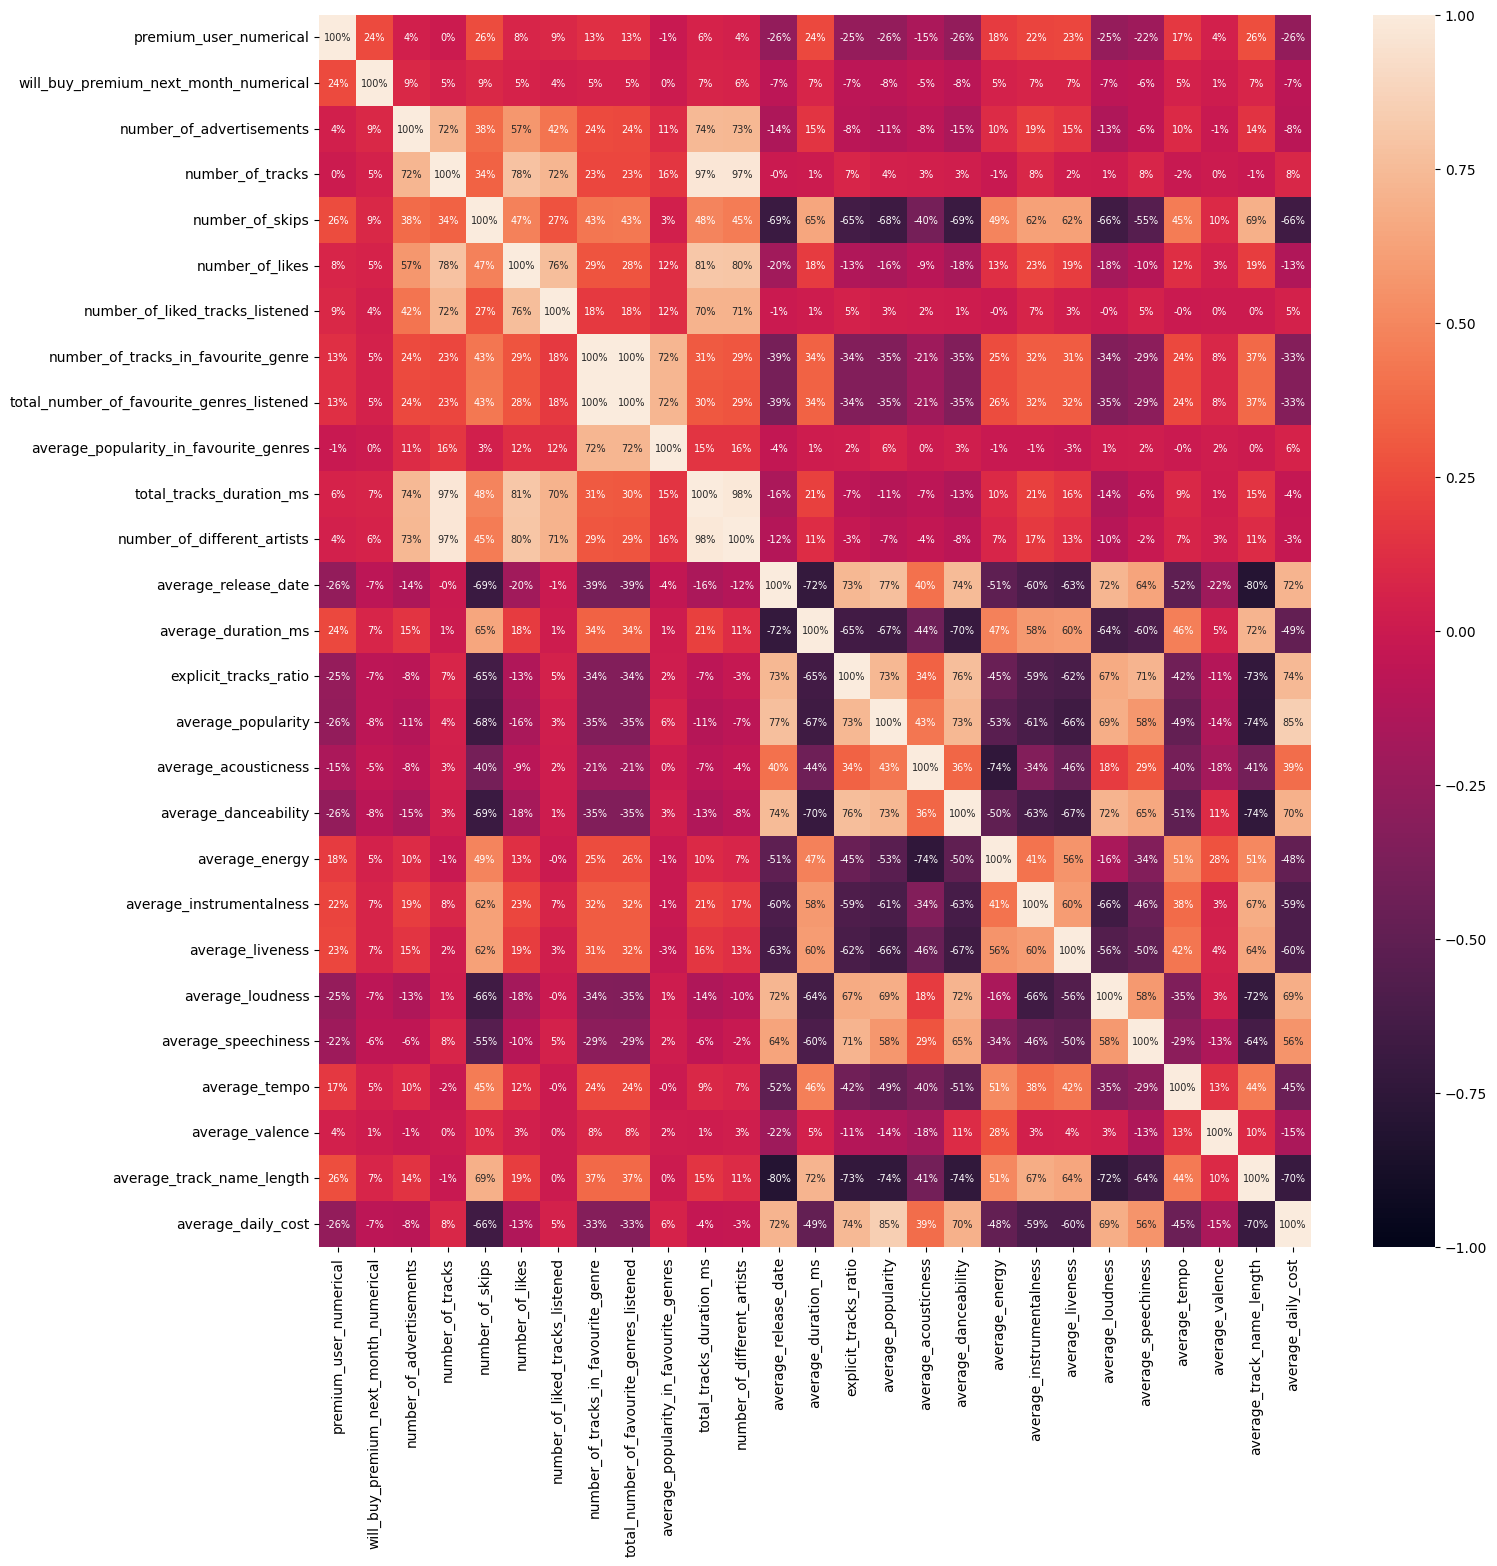

In [5]:
correlation_matrix = data_frame.loc[:, TARGET_AND_FEATURES] \
    .corr(method='spearman')

plt.figure(figsize=(16, 16))

sns.heatmap(
    correlation_matrix,
    xticklabels=correlation_matrix.columns,  # type: ignore
    yticklabels=correlation_matrix.columns,  # type: ignore
    annot=True,
    annot_kws={"fontsize": 7},
    fmt=".0%",
    vmin=-1,
    vmax=1,
)

plt.show()

Definiujemy pipeline do uzupełnienia danych pustych oraz przeskalowania danych

In [6]:
pipeline = Pipeline([
    ("simple_imputer", SimpleImputer()),
    ("standard_scaler", StandardScaler())
])

Dzielimy dane na dane trenujące oraz testowe do późniejszych eksperymentów A/B

In [7]:
TRAINING_UP_TO = 2023
TRAIN_DATA: pd.DataFrame = data_frame.loc[data_frame.year < TRAINING_UP_TO, :]
TEST_DATA: pd.DataFrame = data_frame.loc[data_frame.year >= TRAINING_UP_TO, :]
TEST_SIZE = 0.33

Pipeline tworzony jest na podstawie, tylko i wyłącznie danych testowych


In [8]:
X_train_temp, X_test_temp, Y_train, Y_test = train_test_split(
    TRAIN_DATA[FEATURES],
    TRAIN_DATA[TARGETS],
    test_size=TEST_SIZE
)
X_train_temp: pd.DataFrame
X_test_temp: pd.DataFrame
Y_train: pd.DataFrame
Y_test: pd.DataFrame

train_data = pipeline.fit_transform(X_train_temp)
test_data = pipeline.transform(X_test_temp)
X_train = pd.DataFrame(train_data, columns=FEATURES)
X_test = pd.DataFrame(test_data, columns=FEATURES)

### Cechy przetworzone przez pipeline

In [9]:
X_train.head()

,number_of_advertisements,number_of_tracks,number_of_skips,number_of_likes,number_of_liked_tracks_listened,number_of_tracks_in_favourite_genre,total_number_of_favourite_genres_listened,average_popularity_in_favourite_genres,total_tracks_duration_ms,number_of_different_artists,...,average_danceability,average_energy,average_instrumentalness,average_liveness,average_loudness,average_speechiness,average_tempo,average_valence,average_track_name_length,average_daily_cost
0,-0.859662,-0.974791,-0.540041,-1.651581,-0.509186,0.108451,0.043085,1.390699,-1.102214,-1.100329,...,1.212607,0.311505,-1.007244,-0.357937,1.106392,0.269192,-0.586165,-0.126166,-0.676157,0.014312
1,0.634882,0.198911,0.827503,0.301338,-0.119966,-0.079652,-0.120511,0.173965,0.291527,0.576289,...,-0.976439,2.174423,1.125540,1.089877,-0.609582,-0.746495,1.167213,1.403887,0.182194,-1.134418
2,-0.859662,-1.170408,-0.710984,-0.814616,-0.509186,-0.643963,-0.611301,-1.013800,-1.193540,-1.339846,...,-0.073810,-0.844690,0.420702,0.196312,0.700761,-1.172235,0.321552,-1.947515,-0.893312,1.626961
3,-1.108753,-0.974791,-0.710984,-0.535627,0.074644,-0.643963,-0.611301,-1.013800,-1.026014,-0.980570,...,0.570788,0.095591,-0.626916,-0.720050,0.934085,-0.162226,-1.575812,-0.557854,-0.544103,1.141890
4,-0.112390,1.079187,-0.710984,0.301338,0.074644,-0.643963,-0.611301,-1.013800,0.885071,0.815806,...,0.847049,-1.531306,-0.129261,-0.092601,-0.024219,2.264322,-0.335548,-1.507723,-0.726844,0.306340


In [10]:
Y_train.head()

,premium_user_numerical,will_buy_premium_next_month_numerical
38047,0,0
126255,1,0
81848,1,0
32102,0,0
65703,0,0


# Modele

Do porównywania wybraliśmy cztery modele:

- `Dummy` - naiwny model, który zawsze przewiduje najczęściej występującą klasę
- `Logistic Regression` - model regresji logistycznej z domyślnymi parametrami
- `XGB Classifier` - model XGBoost z domyślnymi parametrami
- `XGB Classifier with Randomize Search` - model XGBoost z Randomize Search. Randomize Search to metoda optymalizacji hiperparametrów, która losowo wybiera zdefiniowaną liczbę kombinacji hiperparametrów i zwraca najlepszą z nich. W ten sposób można znaleźć dobre parametry modelu bez konieczności przeszukiwania całej przestrzeni hiperparametrów.

In [11]:
DUMMY = 'dummy'
LOGISTIC_REG = 'logistic_regression'
XGB = 'xgb_classifier'
XGB_BEST_ESTIMATOR = 'xgb_classifier_best_estimator'
RANDOM = 'randomized_search'


MODEL_TYPES = [DUMMY, LOGISTIC_REG, XGB, XGB_BEST_ESTIMATOR]


def construct_dummy(X_train: pd.DataFrame, y_train: pd.DataFrame, params: Optional[Dict[str, Any]] = None) -> DummyClassifier:
    return DummyClassifier().fit(X_train, y_train)


def construct_logistic_reggression(X_train: pd.DataFrame, y_train: pd.DataFrame, params: Optional[Dict[str, Any]] = None) -> LogisticRegression:
    return LogisticRegression().fit(X_train, y_train)


def construct_xgb_classifier(X_train: pd.DataFrame, y_train: pd.DataFrame, params: Optional[Dict[str, Any]] = None) -> XGBClassifier:
    return XGBClassifier().fit(X_train, y_train)


def construct_xgb_classifier_with_randomized_search(X_train: pd.DataFrame, y_train: pd.DataFrame, params: Optional[Dict[str, Any]] = None) -> XGBClassifier:
    scale = y_train.value_counts()
    if params:
        return XGBClassifier(**params).fit(X_train, y_train)
    model = XGBClassifier(scale_pos_weight=sqrt(scale[0] / scale[1]))
    # TODO: update with own parameters

    randomized_search_cv = RandomizedSearchCV(
        estimator=model,
        param_distributions={
            'max_depth': range(3, 33),  # range(3, 30),
            'eta': uniform(0, 0.25),
            'gamma': uniform(0, 1),
            'n_estimators': range(10, 100),
        },
        n_iter=30,  # 20,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=3,
    )
    estimator = randomized_search_cv.fit(X_train, y_train)
    return estimator.best_estimator_  # type: ignore


MODEL_CONSTRUCTORS = {
    DUMMY: construct_dummy,
    LOGISTIC_REG: construct_logistic_reggression,
    XGB: construct_xgb_classifier,
    XGB_BEST_ESTIMATOR: construct_xgb_classifier_with_randomized_search
}
MODELS: Dict[str, Dict[str, Model]] = {}

for type in MODEL_TYPES:
    MODELS[type] = {
        target: MODEL_CONSTRUCTORS[type](X_train, Y_train[target])
        for target in TARGETS
    }

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


# Ocena modeli

Posiadamy niezbilansowane dane, dlatego też do oceny modeli wykorzystaliśmy metrykę `ROC-AUC`, która jest miarą jakości klasyfikatora binarnego. 

`ROC-AUC` mierzy zdolność modelu do rozróżnienia między dwiema klasami poprzez obliczenie powierzchni pod krzywą ROC. Krzywa ROC przedstawia zależność między wskaźnikiem True Positive Rate = TP / ( TP + FN) (czułość) a False Positive Rate = FP / (FP + TN) (specyficzność). Wyższa wartość ROC-AUC oznacza lepszą zdolność modelu do rozróżniania klas.

Nie wykorzystaliśmy metryki `accuracy`, ponieważ w przypadku niezbilansowanych danych, może ona być myląca. Przykładowo, jeśli mamy 1000 obserwacji, z czego 900 należy do klasy 0, a 100 do klasy 1, to model, który zawsze zwraca 0, będzie miał accuracy 90%.

DUMMY
ROC AUC score for premium_user_numerical: 0.5
ROC AUC score for will_buy_premium_next_month_numerical: 0.5


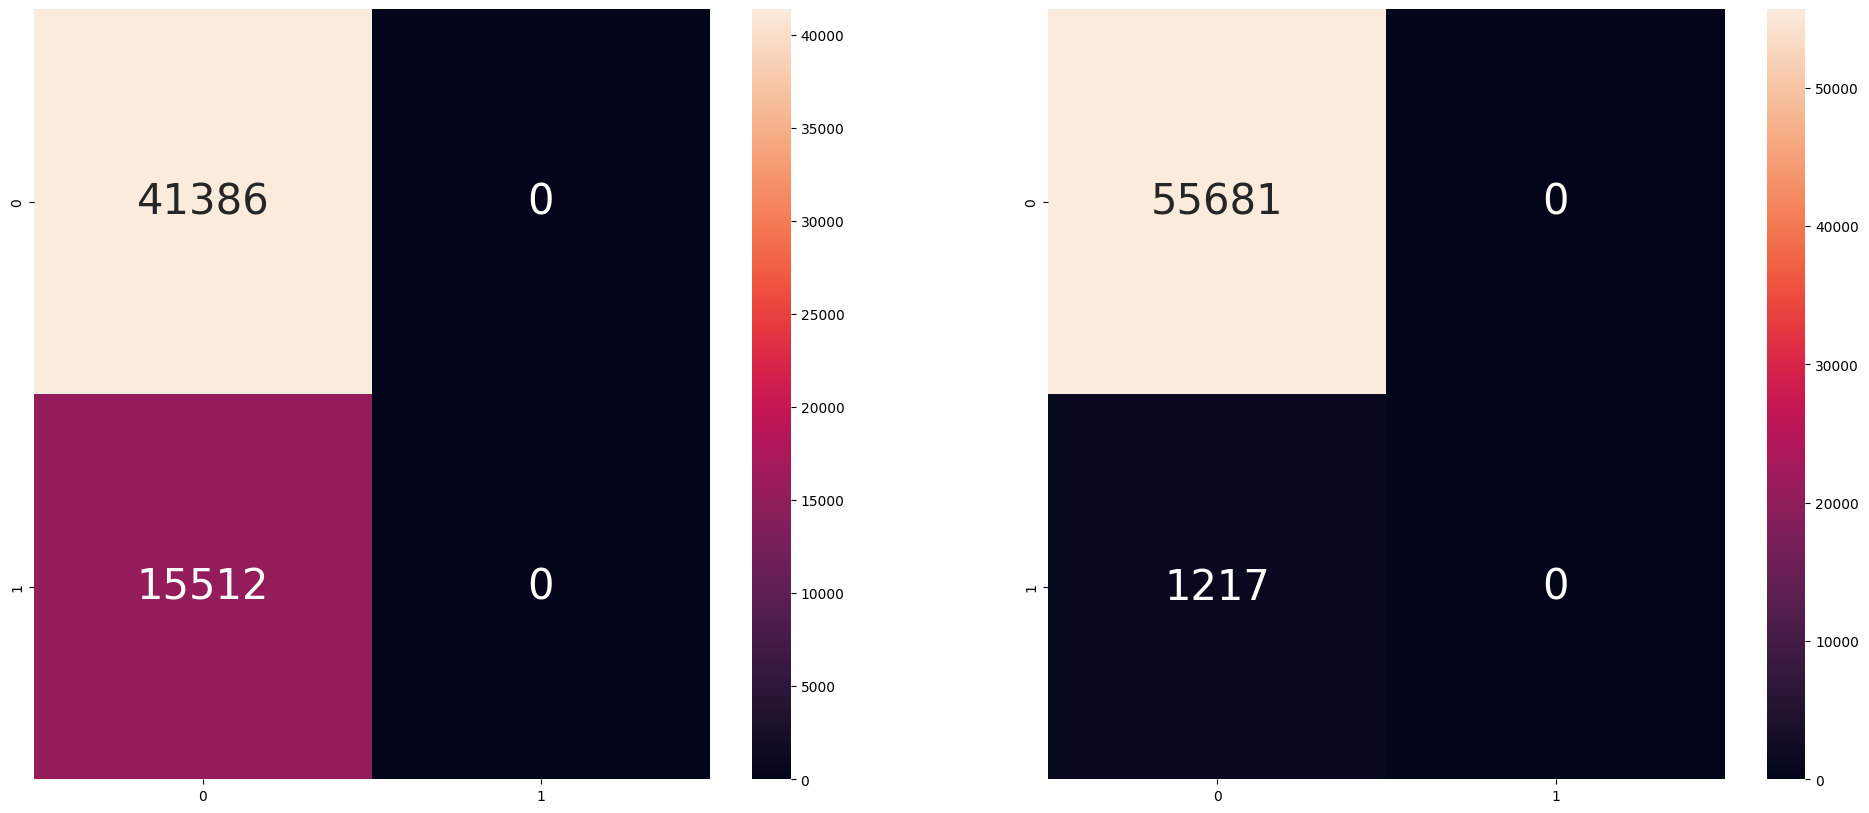

LOGISTIC_REGRESSION
ROC AUC score for premium_user_numerical: 0.5172618654044775
ROC AUC score for will_buy_premium_next_month_numerical: 0.5


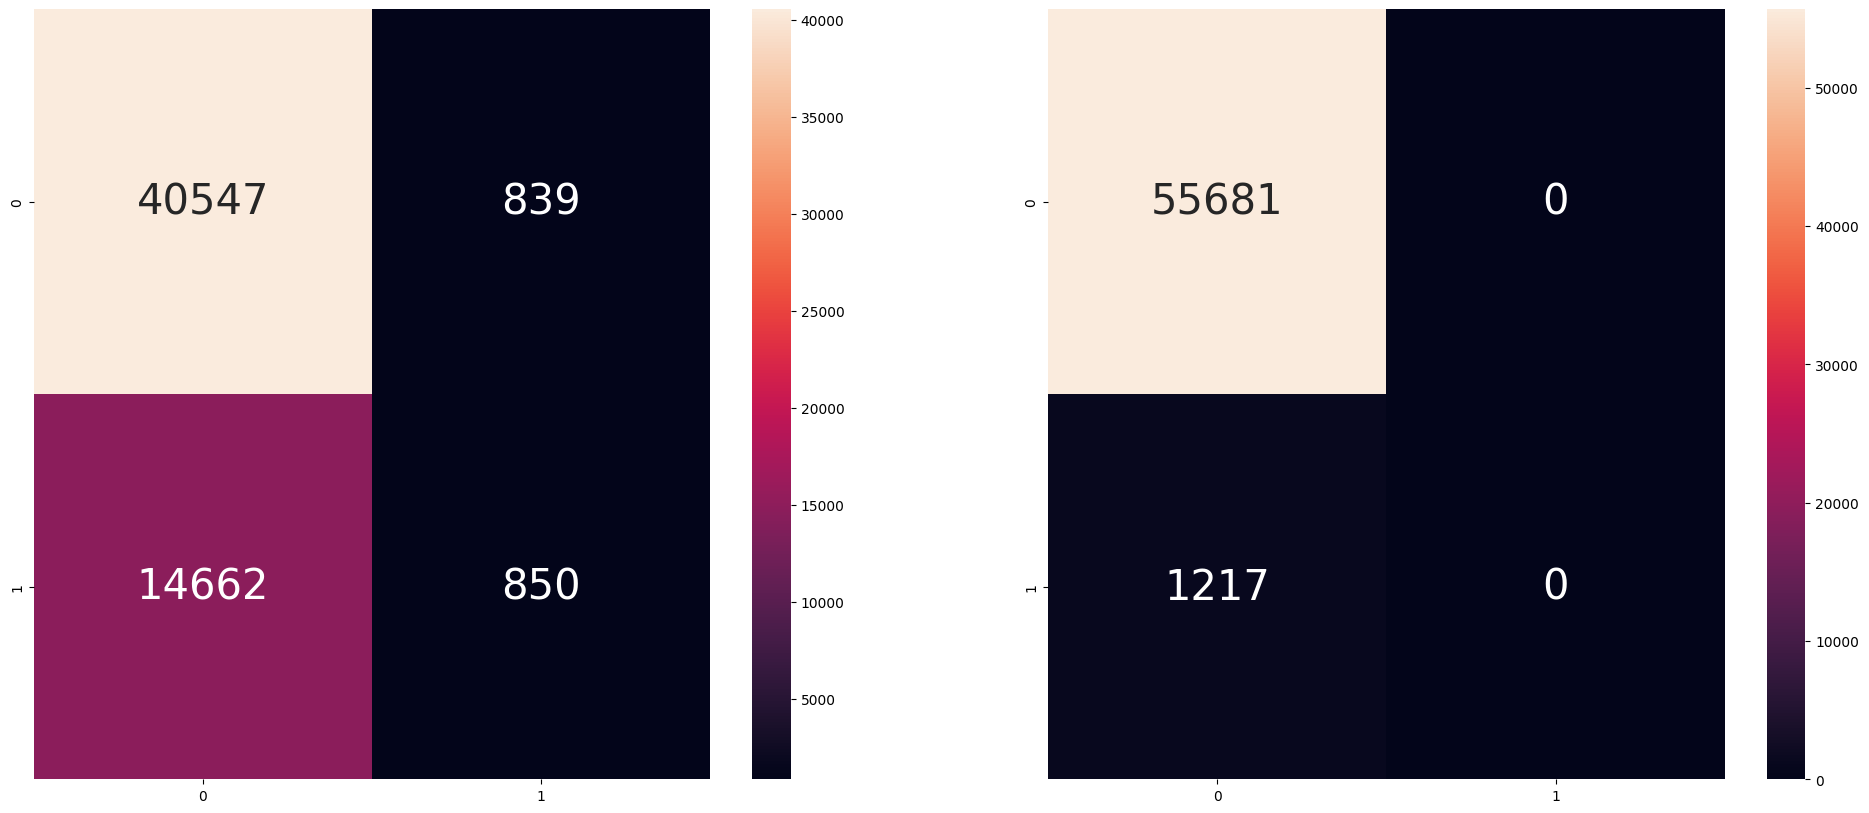

XGB_CLASSIFIER
ROC AUC score for premium_user_numerical: 0.533713164594605
ROC AUC score for will_buy_premium_next_month_numerical: 0.5050895701991346


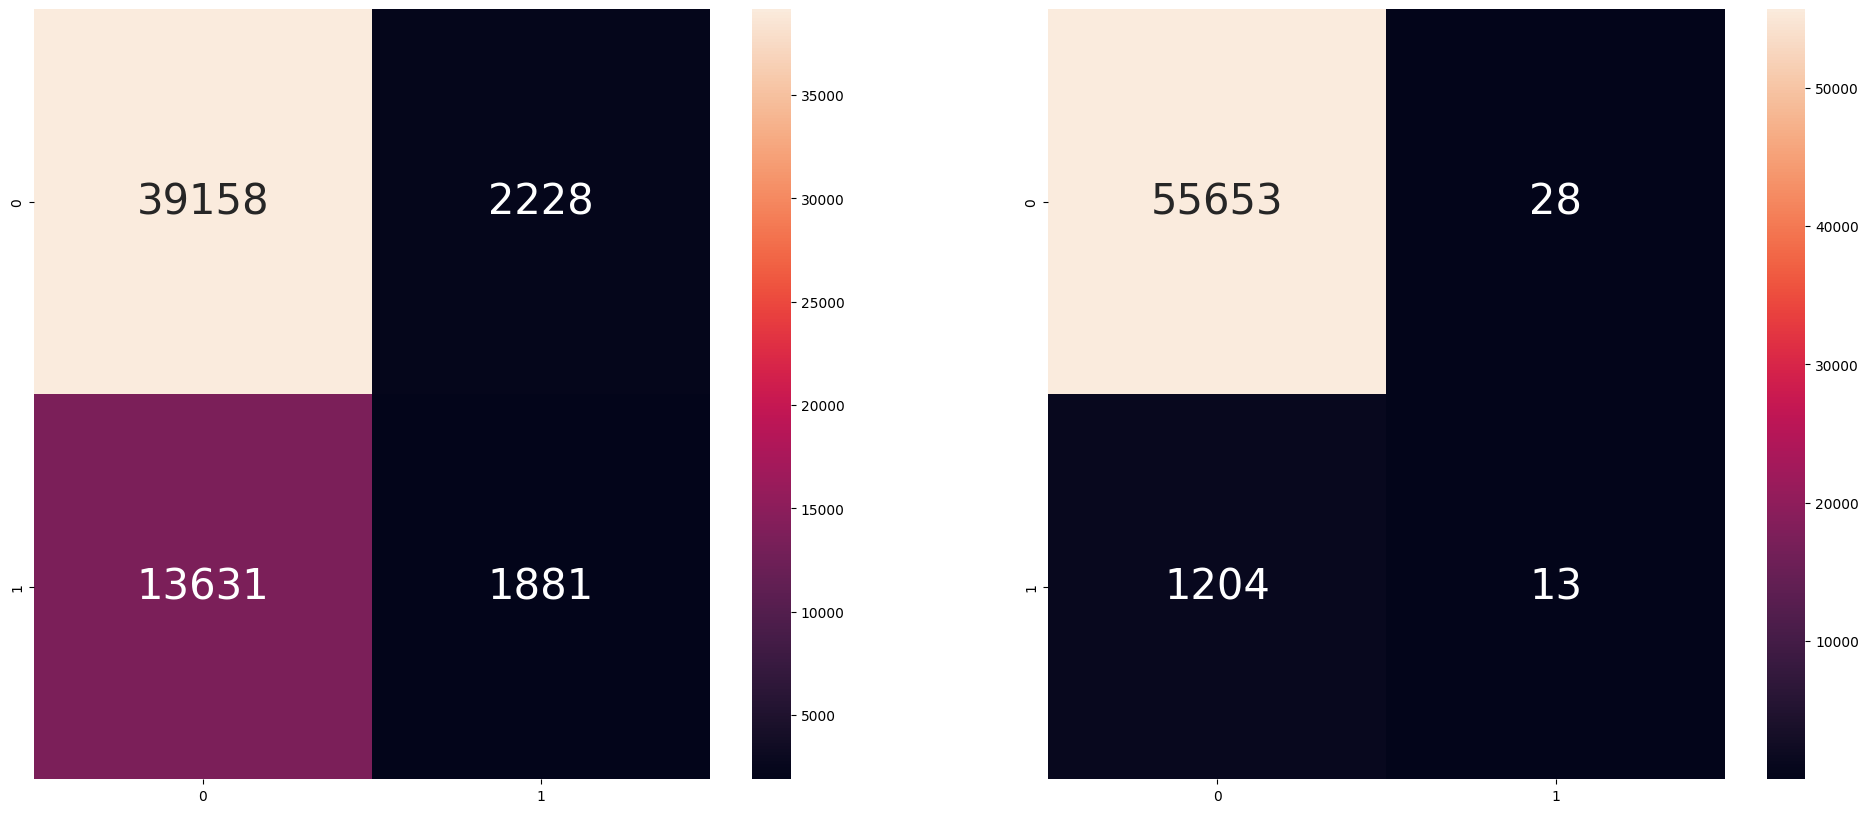

XGB_CLASSIFIER_BEST_ESTIMATOR
ROC AUC score for premium_user_numerical: 0.6734117025694049
ROC AUC score for will_buy_premium_next_month_numerical: 0.5959162518346638


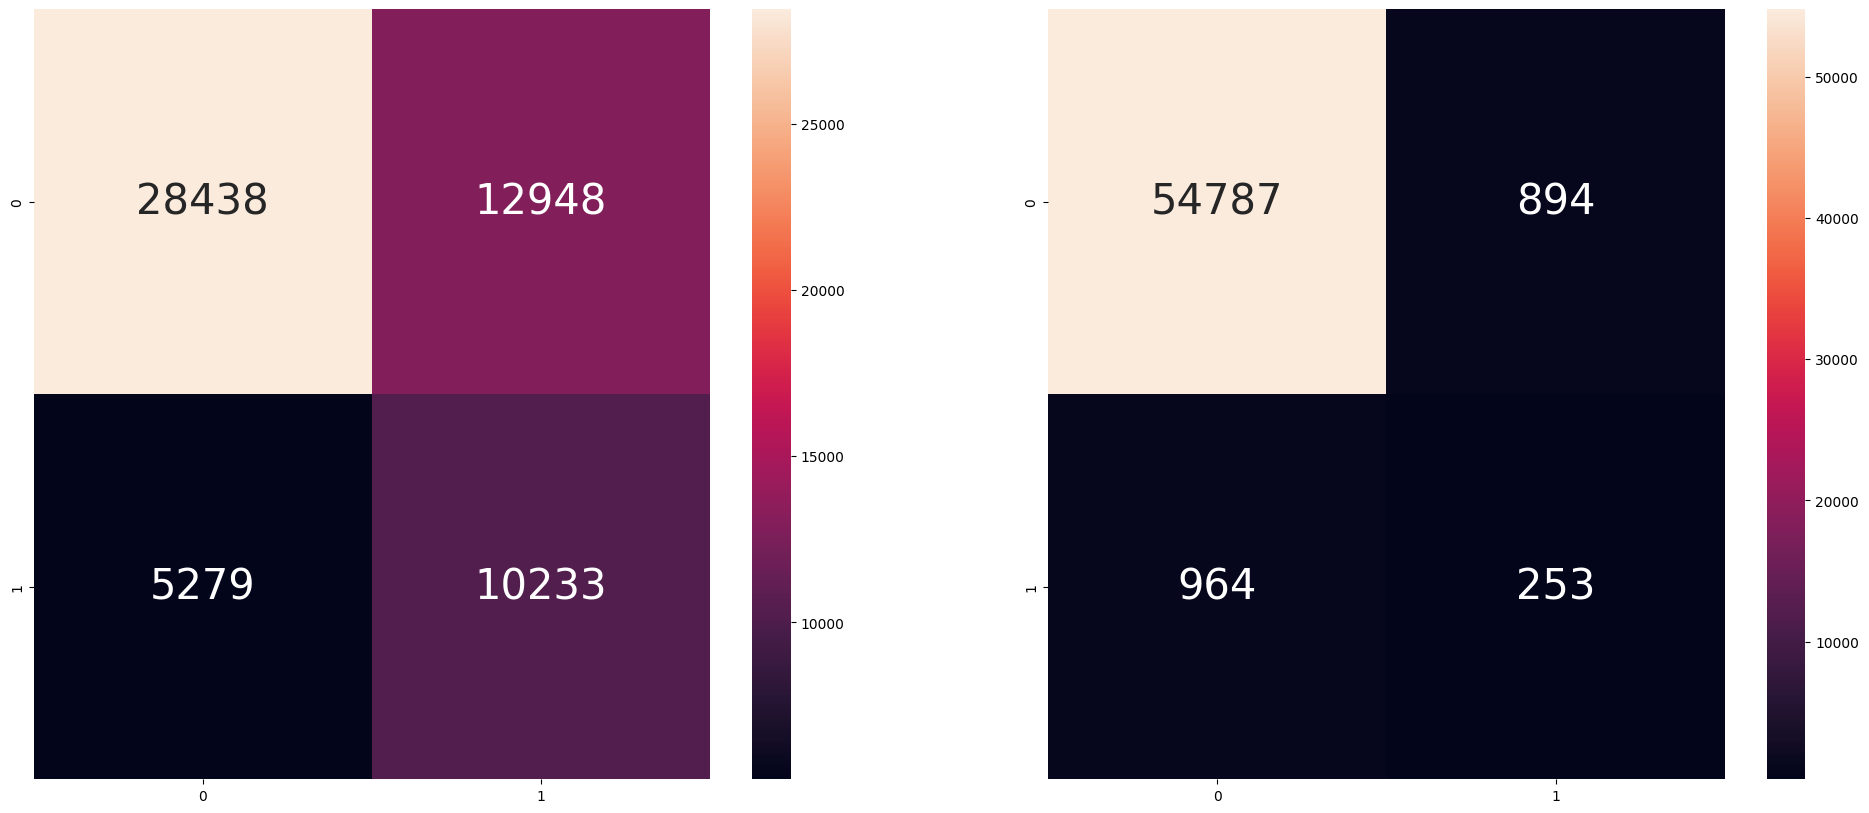

In [12]:
for type in MODEL_TYPES:
    print(type.upper())
    _, axs = plt.subplots(1, 2, figsize=(24, 10))  # type: ignore
    for i, target in enumerate(TARGETS):
        model = MODELS[type][target]
        y_predicted = model.predict(X_test)
        y_true = Y_test[target]
        roc_auc_score_value = roc_auc_score(y_true, y_predicted)
        print(f"ROC AUC score for {target}: {roc_auc_score_value}")
        matrix = confusion_matrix(y_true, y_predicted)
        sns.heatmap(
            matrix,
            annot=True,
            annot_kws={"fontsize": 30},
            fmt='g',
            xticklabels=["0", "1"],  # type: ignore
            yticklabels=["0", "1"],  # type: ignore
            ax=axs[i]  # type: ignore
        )
    plt.show()

### Istotność parametrów
Analizując wyniki możemy zauważyć, że dla przewidywania `premium_user_numerical` (czy użytkownik kiedykolwiek zakupi premium) najgorzej poradził sobie model naiwny `Dummy`, który każdemu przypisuje klasę większościową. Nieznacznie lepsze wyniki na podobnym poziomie, osiągnęły modele `Logistic Regression` oraz `XGB Classifier`. Najlepsze wyniki osiągnął model `XGB Classifier with Randomize Search`, dzięki optymalizacji hiperparametrów. W Przypadku `will_buy_premium_next_month_numerical` wyniki dla `Dummy`, `Logistic Regression` oraz `XGB Classifier` są bliskie 0.5, tak więc model nie jest w stanie przewidzieć czy użytkownik kupi premium w następnym miesiącu. Jedynie model `XGB Classifier with Randomize Search` osiągnął wynik 0.53, co jest nieznacznie lepsze od losowego przewidywania.

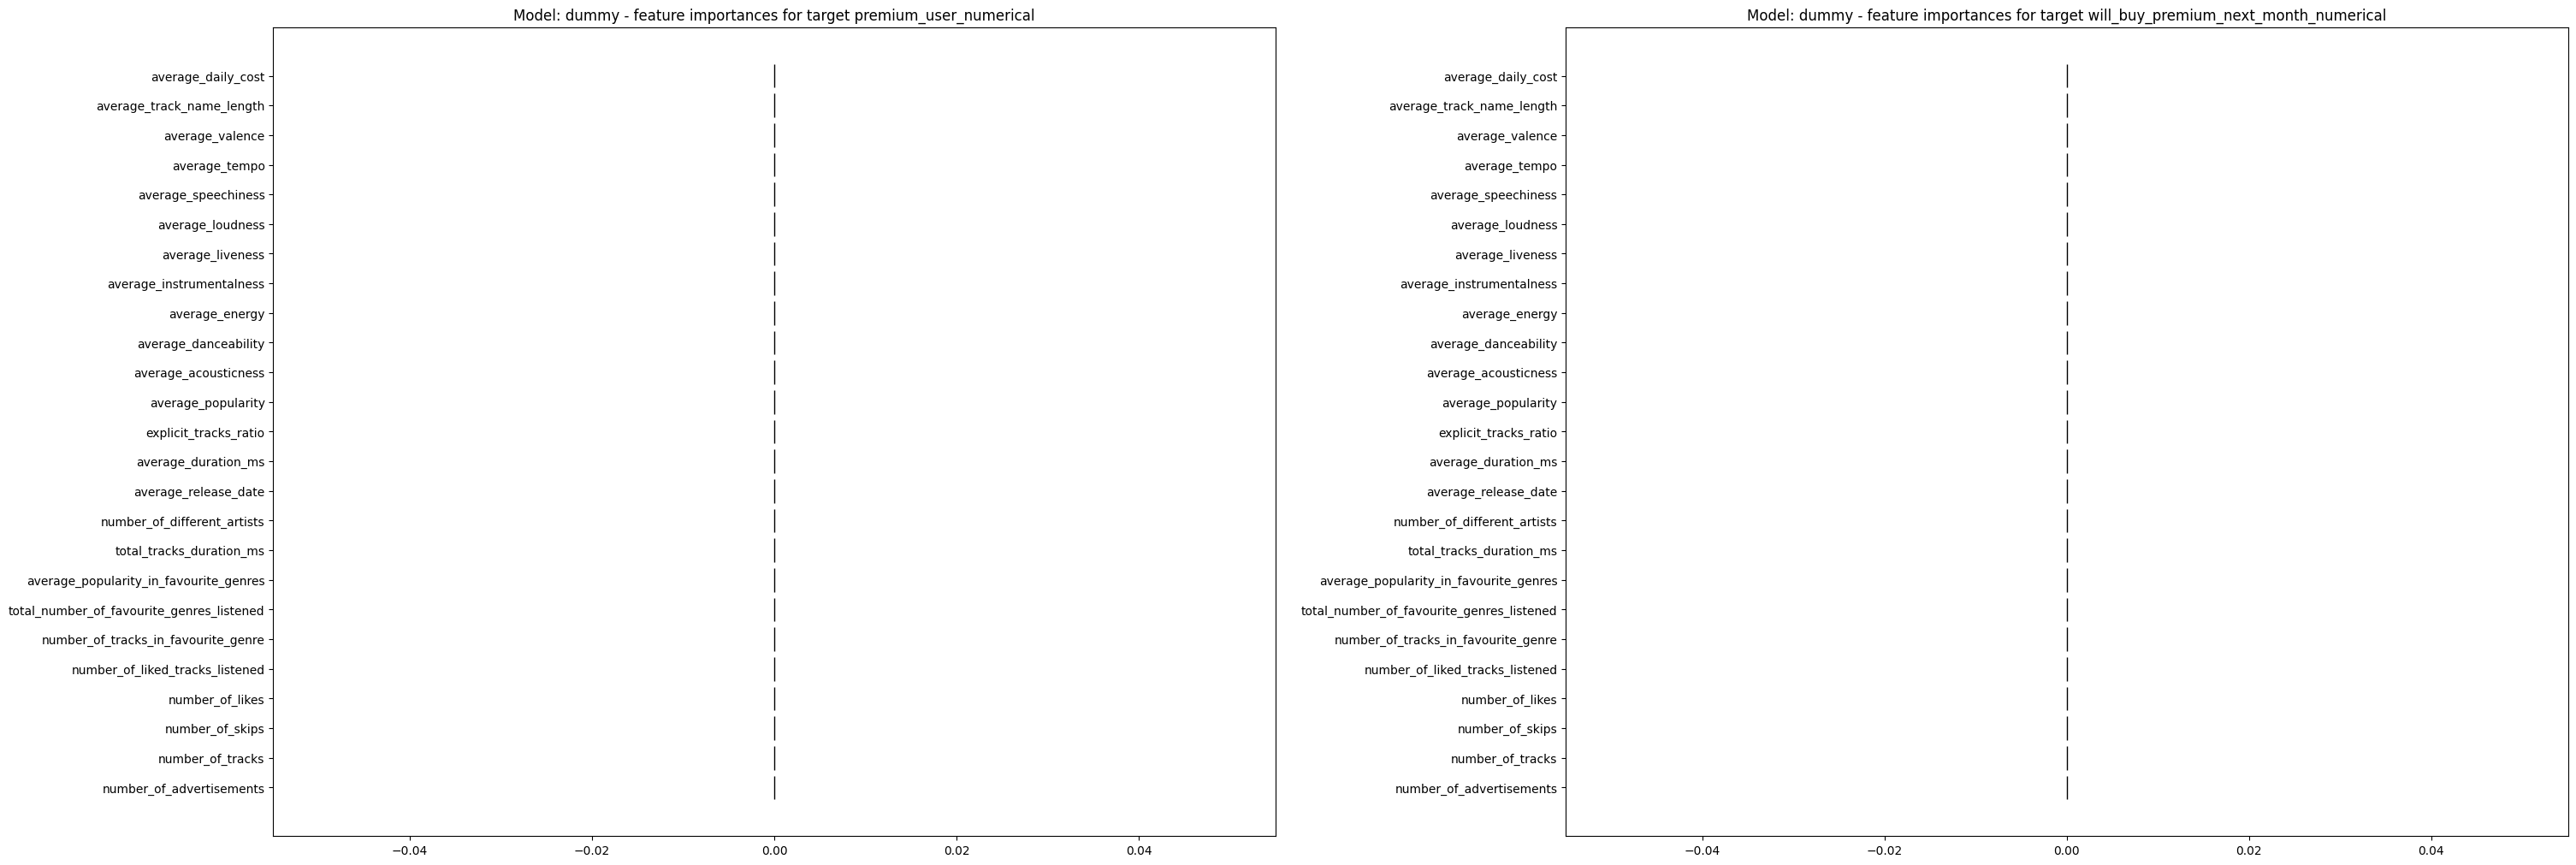

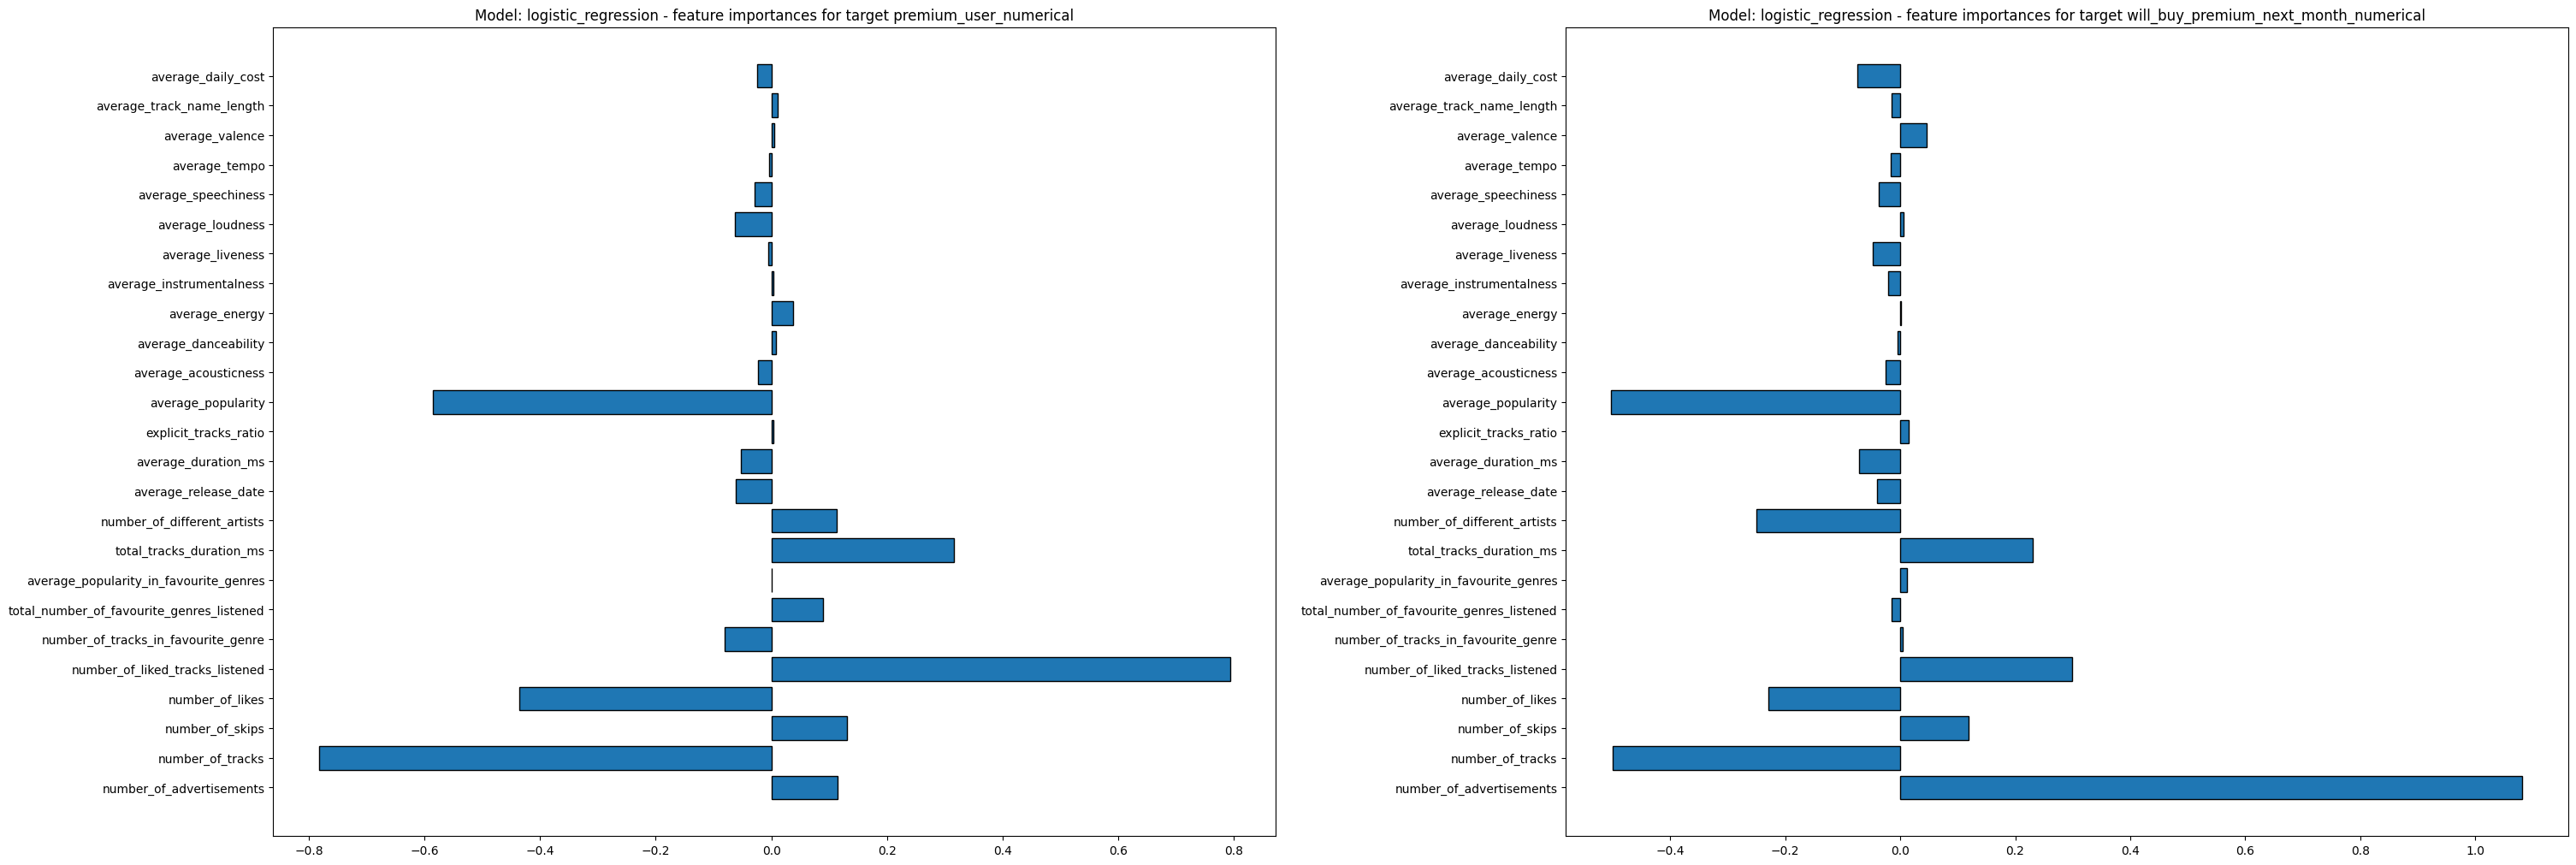

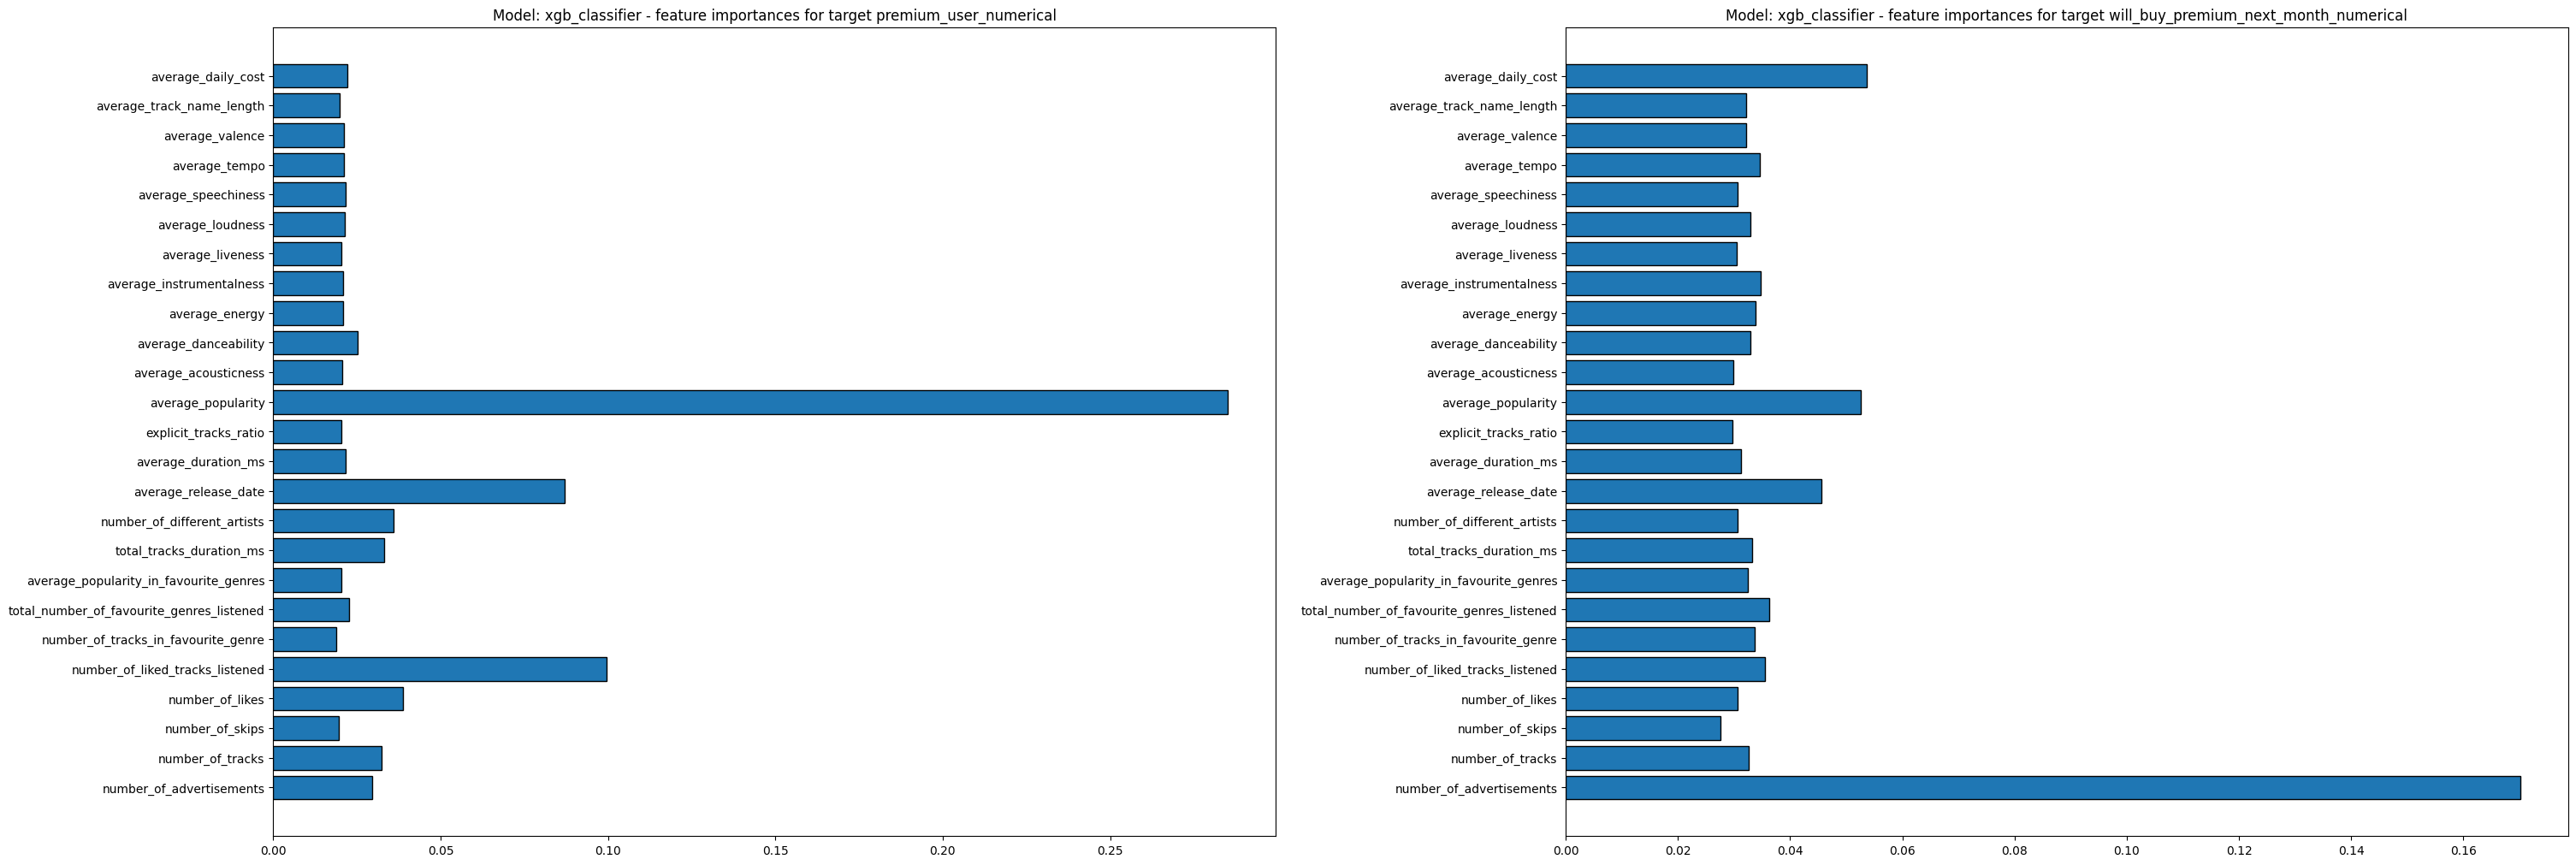

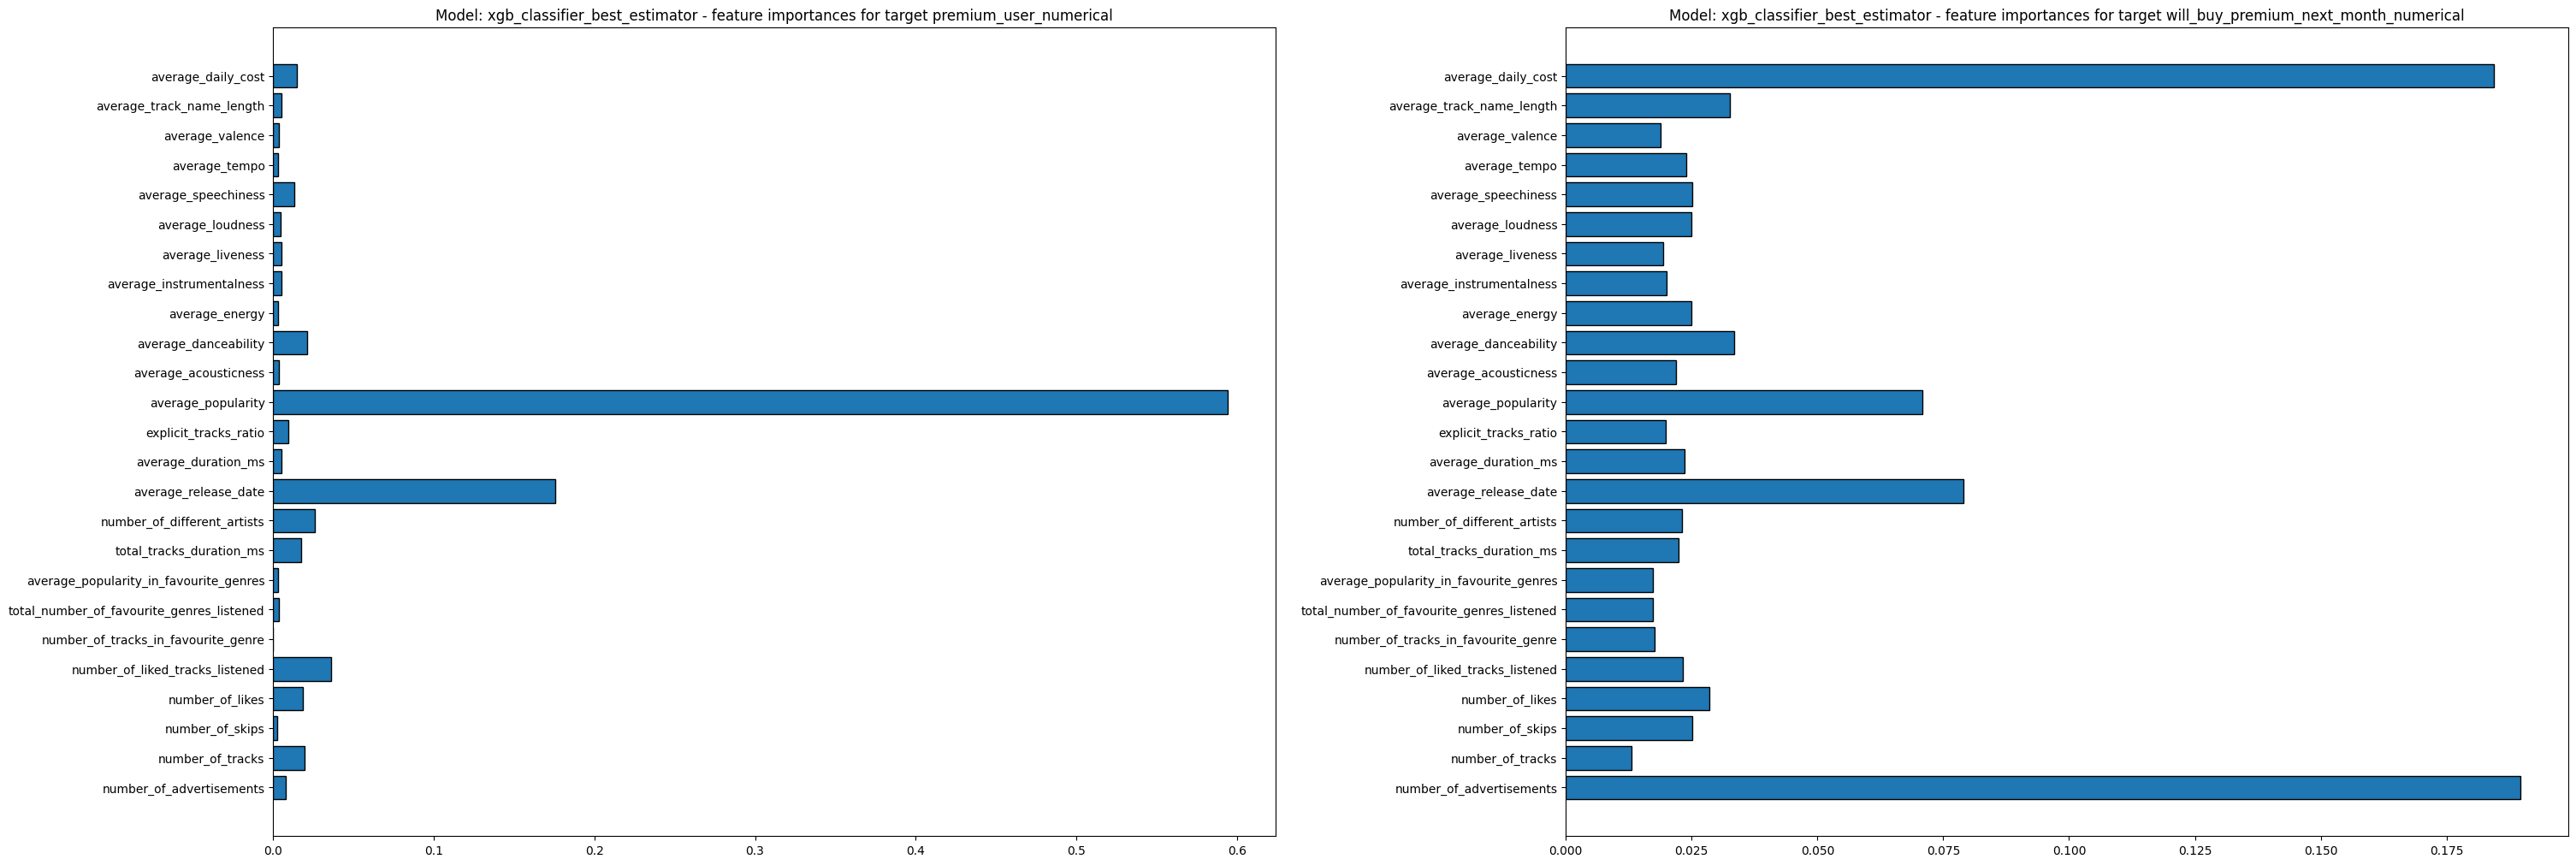

In [13]:
def retrieve_weights(model: Model) -> np.ndarray[np.float64]:
    if isinstance(model, LogisticRegression):
        return model.coef_[0]
    if isinstance(model, XGBClassifier):
        return model.feature_importances_
    return np.zeros(len(FEATURES))


for type in MODEL_TYPES:
    _, axs = plt.subplots(1, len(TARGETS), figsize=(
        30, 10), constrained_layout=True)
    for i, target in enumerate(TARGETS):
        model = MODELS[type][target]
        columns = FEATURES
        weights = retrieve_weights(model)
        axs[i].barh(y=columns, width=weights, edgecolor="black")
        axs[i].set_title(
            f"Model: {type} - feature importances for target {target}")
    plt.show()

Analizując ważność parametrów możemy zauważyć, że większość parametrów jest równie ważna, jednakże kilka z nich wyróżnia się na tle pozostałych. W przypadku przewidywania dla tego, czy użytkownik zakupi premium w następnym miesiącu najważniejszym parametrem jest `number_of_advertisements`, czyli liczba wyświetlanych reklam. Tak, więc jeżeli chcemy aby użytkownik jak najszybciej zakupił premium powinniśmy wyświetlać mu jak najwięcej reklam. Natomiast w przypadku przewidywania tego, czy użytkownik kiedykolwiek zakupi premium ważniejsze staje się `average_popularity` oraz `number_of_licked_tracks_listened` co oznacza, że użytkownicy, którzy słuchają popularniejszych utworów oraz słuchają polubionych utworów są bardziej skłonni do zakupu premium. Może oznaczać, to, że w długofalowej perspektywie ważniejsze może być wyświetlanie użytkownikowi utworów, które są popularne oraz utworów, które użytkownik polubił, niż wyświetlanie reklam. 

In [14]:
# temp = 10
# plots = []
# MONTHS = 60
# subplots = [plt.subplots(4, MONTHS//4, figsize=(100, 40))
#             [1].flatten() for _ in TARGETS]
# plot_statistics = []
# for year, month in itertools.product(range(2019, 2023), range(1, 13)):
#     temp += 1
#     if temp % 10 != 0:
#         continue
#     data_train = data_frame.loc[
#         data_frame.apply(lambda x: x.year < year or (
#             x.month <= month and x.year == year), axis=1),
#         :
#     ]
#     if len(data_train) == 0:
#         continue
#     data_test = data_frame.loc[
#         data_frame.apply(lambda x: (x.month == month + 1 and x.year == year)
#                          or (x.year == year + 1 and x.month == 1), axis=1),
#         :
#     ]
#     x_train, y_train = data_train[FEATURES], data_train[TARGETS]
#     x_test, y_test = data_test[FEATURES], data_test[TARGETS]

#     plots.append(create_plot_from_model(x_train, y_train, x_test, y_test, [
#                  subplot[temp] for subplot in subplots], XGBClassifier, randomized_search_cv.best_params_))

# plt.show()

In [15]:
# TODO: F1 score, Precision, Recall figures

### Eksperymenty A/B
Trenujemy wszystkie modele na danych do 2023, a wyniki dla wszystkich modeli zapisujemy do plików pkl. Uruchamiamy mikroserwis, który wczytuje te modele. Następnie dane użytkowników korzystających w roku 2023 dzielimy na różne rzeczywistości i dla każdej z tych grup wykonujemy predykcję z wykorzystaniem naszego mikroserwisu, a następnie przeprowadzamy porównanie za pomocą testu t-studenta.

In [16]:
def get_params(model: Model) -> Optional[Dict[str, Any]]:
    if isinstance(model, XGBClassifier):
        return model.get_params()
    return None


X_train = pd.DataFrame(
    pipeline.fit_transform(TRAIN_DATA[FEATURES]),
    columns=FEATURES
)
Y_train = TRAIN_DATA[TARGETS]
for type in MODEL_TYPES:
    estimators = {}
    for target in TARGETS:
        y_train = Y_train[target]
        estimators[target] = MODEL_CONSTRUCTORS[type](
            X_train, y_train, get_params(MODELS[type][target])
        )
    model = IUMModel(pipeline, estimators)
    with open(f'models/{type}.pkl', 'wb') as f:
        pickle.dump(model, f)

In [17]:
random_ordered_ids = np.random.permutation(TEST_DATA['user_id'].unique())
size = len(random_ordered_ids) // len(MODEL_TYPES)

REALITIES: Dict[str, pd.DataFrame] = {}

for i, type in enumerate(MODEL_TYPES):
    ids = random_ordered_ids[i * size:(i + 1) * size]
    mask = TEST_DATA['user_id'].isin(ids)
    REALITIES[type] = TEST_DATA.loc[mask]

In [18]:
for type in MODEL_TYPES:
    display(REALITIES[type].head())

,user_id,year,month,premium_user_numerical,will_buy_premium_next_month_numerical,number_of_premium,number_of_advertisements,number_of_tracks,number_of_skips,number_of_likes,...,average_danceability,average_energy,average_instrumentalness,average_liveness,average_loudness,average_speechiness,average_tempo,average_valence,average_track_name_length,average_daily_cost
2129,5945,2023,1,1,1,1,17,32,0,9,...,0.654094,0.547312,0.045521,0.120609,-7.680031,0.067134,111.153844,0.473512,12.312500,0.023636
2867,583,2023,3,1,1,0,11,31,15,11,...,0.441774,0.660419,0.066486,0.241710,-8.348548,0.060265,123.085516,0.419452,22.258065,0.013564
2871,583,2023,1,1,0,0,9,26,14,12,...,0.490654,0.650154,0.038742,0.208819,-9.152346,0.056335,119.740885,0.494846,20.923077,0.013688
2943,10173,2023,2,1,1,0,11,36,2,5,...,0.611306,0.557056,0.008194,0.135256,-7.189000,0.059411,113.502861,0.495778,14.416667,0.022563
3928,861,2023,1,0,0,0,8,28,0,4,...,0.666714,0.594036,0.014506,0.158546,-6.755464,0.132286,117.240643,0.490407,11.964286,0.023093


,user_id,year,month,premium_user_numerical,will_buy_premium_next_month_numerical,number_of_premium,number_of_advertisements,number_of_tracks,number_of_skips,number_of_likes,...,average_danceability,average_energy,average_instrumentalness,average_liveness,average_loudness,average_speechiness,average_tempo,average_valence,average_track_name_length,average_daily_cost
328,7643,2023,1,1,0,0,10,26,11,11,...,0.481962,0.644192,0.122086,0.228292,-9.241962,0.066550,125.406462,0.468627,25.692308,0.013864
331,7643,2023,1,1,0,0,7,26,14,9,...,0.499385,0.719962,0.071406,0.198385,-8.612577,0.056546,124.025731,0.591512,22.192308,0.012140
378,14848,2023,3,1,1,0,15,36,2,5,...,0.648306,0.512556,0.027164,0.155794,-7.668833,0.087006,106.619583,0.463817,13.333333,0.023180
2378,9065,2023,3,1,1,0,11,36,0,8,...,0.678528,0.589583,0.030580,0.149925,-6.894583,0.083008,114.375944,0.515417,14.194444,0.022362
2836,17778,2023,1,1,1,0,9,32,1,10,...,0.616688,0.566781,0.097120,0.207247,-7.540094,0.089953,113.637219,0.393766,12.125000,0.024966


,user_id,year,month,premium_user_numerical,will_buy_premium_next_month_numerical,number_of_premium,number_of_advertisements,number_of_tracks,number_of_skips,number_of_likes,...,average_danceability,average_energy,average_instrumentalness,average_liveness,average_loudness,average_speechiness,average_tempo,average_valence,average_track_name_length,average_daily_cost
41,4074,2023,3,1,1,0,1,6,0,2,...,0.626167,0.560333,0.005269,0.148200,-6.978667,0.128867,134.761333,0.527667,7.333333,0.019577
47,4074,2023,1,1,0,0,13,37,3,9,...,0.673216,0.623946,0.022808,0.185284,-6.816027,0.093181,115.215946,0.511486,11.405405,0.026657
3385,15047,2023,1,1,1,1,14,39,19,14,...,0.487282,0.719385,0.127397,0.201549,-8.873872,0.063238,125.130744,0.527464,23.615385,0.012737
3707,7323,2023,1,1,0,0,14,37,23,14,...,0.454351,0.636351,0.107274,0.226873,-9.253568,0.057386,119.483946,0.497930,22.621622,0.013936
3715,7323,2023,1,1,0,0,7,17,9,4,...,0.463353,0.718647,0.025163,0.211929,-8.958882,0.049318,129.466176,0.521347,19.000000,0.011238


,user_id,year,month,premium_user_numerical,will_buy_premium_next_month_numerical,number_of_premium,number_of_advertisements,number_of_tracks,number_of_skips,number_of_likes,...,average_danceability,average_energy,average_instrumentalness,average_liveness,average_loudness,average_speechiness,average_tempo,average_valence,average_track_name_length,average_daily_cost
443,18214,2023,1,1,1,0,4,16,9,3,...,0.480187,0.652187,0.045305,0.223931,-9.035750,0.043562,115.447125,0.474750,24.375000,0.014265
457,18501,2023,1,1,1,0,13,28,13,10,...,0.478964,0.671143,0.065366,0.224946,-8.977607,0.057068,127.819821,0.572821,21.571429,0.012536
474,1944,2023,1,1,1,0,7,27,13,10,...,0.505333,0.657370,0.132346,0.151230,-9.610593,0.081237,129.688852,0.569074,19.925926,0.011697
483,1944,2023,1,1,1,0,5,13,7,7,...,0.488308,0.625231,0.189436,0.269831,-9.640538,0.051131,125.086231,0.607846,31.461538,0.012755
942,11621,2023,3,1,1,1,15,37,1,5,...,0.666946,0.577703,0.015345,0.137381,-6.718757,0.084957,108.457351,0.506541,13.189189,0.023551


In [19]:
result = {
    type: {
        target: pd.DataFrame({
            "guess": [],
            "ground_truth": [],
            "model": [],
            "year": [],
            "month": [],
            "user_id": [],
        })
        for target in TARGETS
    }
    for type in MODEL_TYPES
}

for type in MODEL_TYPES:
    url = f'http://127.0.0.1:5000/predict/{type}'
    for i in range(0, len(TEST_DATA)):
        row = TEST_DATA.iloc[i].to_dict()
        response = requests.post(url, json=row).json()
        for target in TARGETS:
            current = pd.DataFrame({
                "guess": [1 if response[target] else 0],
                "ground_truth": [row[target]],
                "model": [type],
                "year": [row['year']],
                "month": [row['month']],
                "user_id": [row['user_id']],
            })
            result[type][target] = pd.concat(
                [result[type][target], current], ignore_index=True
            )

ConnectionError: HTTPConnectionPool(host='127.0.0.1', port=5000): Max retries exceeded with url: /predict/dummy (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x00000211369E9390>: Failed to establish a new connection: [WinError 10061] Nie można nawiązać połączenia, ponieważ komputer docelowy aktywnie go odmawia'))

In [ ]:
for type in MODEL_TYPES:
    print(type.upper())
    for target in TARGETS:
        print(target)
        print()
        print(result[type][target].guess.value_counts())
        print()
        print(result[type][target].ground_truth.value_counts())
        roc_auc_score_value = roc_auc_score(
            result[type][target].ground_truth, result[type][target].guess
        )
        print()
        print('ROC AUC score = ', roc_auc_score_value)
        print()

In [ ]:
for type in MODEL_TYPES:
    for target in TARGETS:
        result[type][target].to_csv(f'ab_experiment/{type}-{target}.csv')

In [ ]:
BUCKETS = 12
T_ALPHA = 2.074


def s_p(sigma_A: float, sigma_B: float) -> float:
    return sqrt(
        (BUCKETS - 1) * (sigma_A ** 2) + (BUCKETS - 1) * (sigma_B ** 2)
        / (BUCKETS + BUCKETS - 2)
    )


def t(q_A: float, q_B: float, s_p_value: float) -> float:
    return (q_A - q_B) / (s_p_value * sqrt(1 / BUCKETS + 1 / BUCKETS))

In [ ]:
for type_A, type_B in itertools.product(MODEL_TYPES, MODEL_TYPES):
    if type_A == type_B:
        continue
    print(f'{type_A} vs {type_B}'.upper())
    print()
    for target in TARGETS:
        print(target)
        reality_A: pd.DataFrame = result[type_A][target]
        reality_B: pd.DataFrame = result[type_B][target]

        data = pd.concat([reality_A, reality_B])
        random_ordered_ids = np.random.permutation(
            data['user_id'].unique()
        )
        size = len(random_ordered_ids) // BUCKETS

        reality_A_score = []
        reality_B_score = []

        for bucket in range(BUCKETS):
            ids = random_ordered_ids[bucket * size:(i + 1) * size]
            mask = data['user_id'].isin(ids)
            bucket_data = data.loc[mask]
            reality_A_data = bucket_data.loc[bucket_data['model'] == type_A]
            reality_B_data = bucket_data.loc[bucket_data['model'] == type_B]

            reality_A_score.append(
                roc_auc_score(
                    reality_A_data['ground_truth'],
                    reality_A_data['guess'],
                )
            )
            reality_B_score.append(
                roc_auc_score(
                    reality_B_data['ground_truth'],
                    reality_B_data['guess']
                )
            )

        s_p_value = s_p(stdev(reality_A_score), stdev(reality_B_score))
        if s_p_value != 0:
            t_value = t(mean(reality_A_score), mean(
                reality_B_score), s_p_value)
        else:
            t_value = 0

        if t_value > T_ALPHA:
            print(f'{type_A} is better than {type_B}')
        else:
            print(f'We can\'t say that {type_A} is better than {type_B}')
        print()